<a href="https://colab.research.google.com/github/matheusdasilvaoliveira/jogo-de-sucesso/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns
from kagglehub import KaggleDatasetAdapter
import numpy as np
import math, calendar
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# @title Importando dataframe do kaggle
file_path = "games.json"
dfTemp = kagglehub.load_dataset( KaggleDatasetAdapter.PANDAS,"fronkongames/steam-games-dataset", file_path)

df = dfTemp.T

/tmp/ipython-input-3326533571.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  dfTemp = kagglehub.load_dataset( KaggleDatasetAdapter.PANDAS,"fronkongames/steam-games-dataset", file_path)


100%|██████████| 675M/675M [00:08<00:00, 81.6MB/s]


In [ ]:
# @title Analise Inicial do DataSet  - antes da limpeza

#Separando 40% dos registros
#df_sample = df.sample(n=44_580, random_state=42)
df_sample = df

#Informações gerais sobre o DataFrame repartido

print("Formato (linhas, colunas):", df_sample.shape)
print("\nTipos de dados e memória:")
print(df_sample.info(memory_usage='deep'))

print("\nValores nulos (top 20 colunas com mais NaN):")
print(df_sample.isnull().sum().sort_values(ascending=False).head(20))

print("\nPrimeiras 3 linhas do DataFrame:")
print(df_sample.head(3))

Formato (linhas, colunas): (111452, 42)

Tipos de dados e memória:
<class 'pandas.core.frame.DataFrame'>
Index: 111452 entries, 20200 to 3183790
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   name                      111452 non-null  object
 1   release_date              111452 non-null  object
 2   required_age              111452 non-null  object
 3   price                     111452 non-null  object
 4   dlc_count                 111452 non-null  object
 5   detailed_description      111452 non-null  object
 6   about_the_game            111452 non-null  object
 7   short_description         111452 non-null  object
 8   reviews                   111452 non-null  object
 9   header_image              111452 non-null  object
 10  website                   111452 non-null  object
 11  support_url               111452 non-null  object
 12  support_email             111452 non-null  obje

# Conclusões da Analise Inicial:
### Colunas que podem ser descartadas:
 - name: só serve para identificar o jogo
 - website, supportUrl, supportEmail: dados de contato
 - header_image, screenshots, movies: links/imagens
 - metacritic_url: só o metacritic_score já basta.
 - packages: ids de pacotes de venda, não agregam valor direto.
 - detailed_description, about_the_game, short_description, reviews: trabalhar com textos não vai ser o foco.
 - discount: tem muitos NaN e constantemente muda.

### Insights:
- Preço x Sucesso: Ver se jogos mais baratos vendem mais (correlação price vs estimated_owners ou recommendations).
- Avaliações x Jogadores: Ver se jogos com mais avaliações positivas (positive, user_score, metacritic_score) realmente têm mais jogadores (estimated_owners, peak_ccu)
- Tempo de jogo médio: Ver se há relação entre average_playtime_forever e retenção/sucesso. Jogos com muitas horas jogadas podem indicar alta qualidade/replayability.
- Outliers: Alguns jogos terão preço muito alto, ou owners extremamente acima da média (como CS:GO, Dota 2). Esses precisam ser tratados ou normalizados no modelo.
- Gêneros & Tags: alguns gêneros podem estar saturados, outros aparecem menos mas têm alta taxa de engajamento, pode revelar nichos promissores.

### Observações:
- price: Numérico, porém alguns são 0 (gratuitos) e outros 0.99 etc, muitos zeros podem distorcer estatísticas, talvez separar jogos pagos dos gratuitos.
- average_playtime_forever, average_playtime_2weeks, median_playtime_forever, median_playtime_2weeks: Muitos 0, provavelmente jogos comprados mas nunca jogados
- peak_ccu: Pico de jogadores simultâneos, pode ser uma métrica de sucesso.
- coluna estimated_owners: intervalo no formato string, precisamos talvez fazer a media de pessoas que possuem o jogo.
- O campo tags parece rico para clustering ou recomendação, mas precisa ser expandido.


In [ ]:
# @title Estatisticas das variaveis numericas - antes da limpeza
numeric_cols = [
    'price',
    'average_playtime_forever',
    'average_playtime_2weeks',
    'median_playtime_forever',
    'median_playtime_2weeks',
    'peak_ccu',
    'metacritic_score',
    'user_score',
    'positive',
    'negative',
]

for col in numeric_cols:
    df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce')

print("\nResumo estatístico das variáveis numéricas:")
print(df_sample.describe(include=[np.number]).T)


Resumo estatístico das variáveis numéricas:
                             count        mean           std  min   25%   50%  \
price                     111452.0    7.061568     12.563246  0.0  0.99  3.99   
metacritic_score          111452.0    2.623354     13.736245  0.0  0.00  0.00   
user_score                111452.0    0.030408      1.565136  0.0  0.00  0.00   
positive                  111452.0  754.352528  21394.098125  0.0  0.00  3.00   
negative                  111452.0  125.859177   4002.844431  0.0  0.00  1.00   
average_playtime_forever  111452.0   81.247290    999.935906  0.0  0.00  0.00   
average_playtime_2weeks   111452.0    9.174954    168.201030  0.0  0.00  0.00   
median_playtime_forever   111452.0   72.651330   1321.333137  0.0  0.00  0.00   
median_playtime_2weeks    111452.0    9.891038    183.232812  0.0  0.00  0.00   
peak_ccu                  111452.0  177.721548   8390.461768  0.0  0.00  0.00   

                            75%         max  
price            

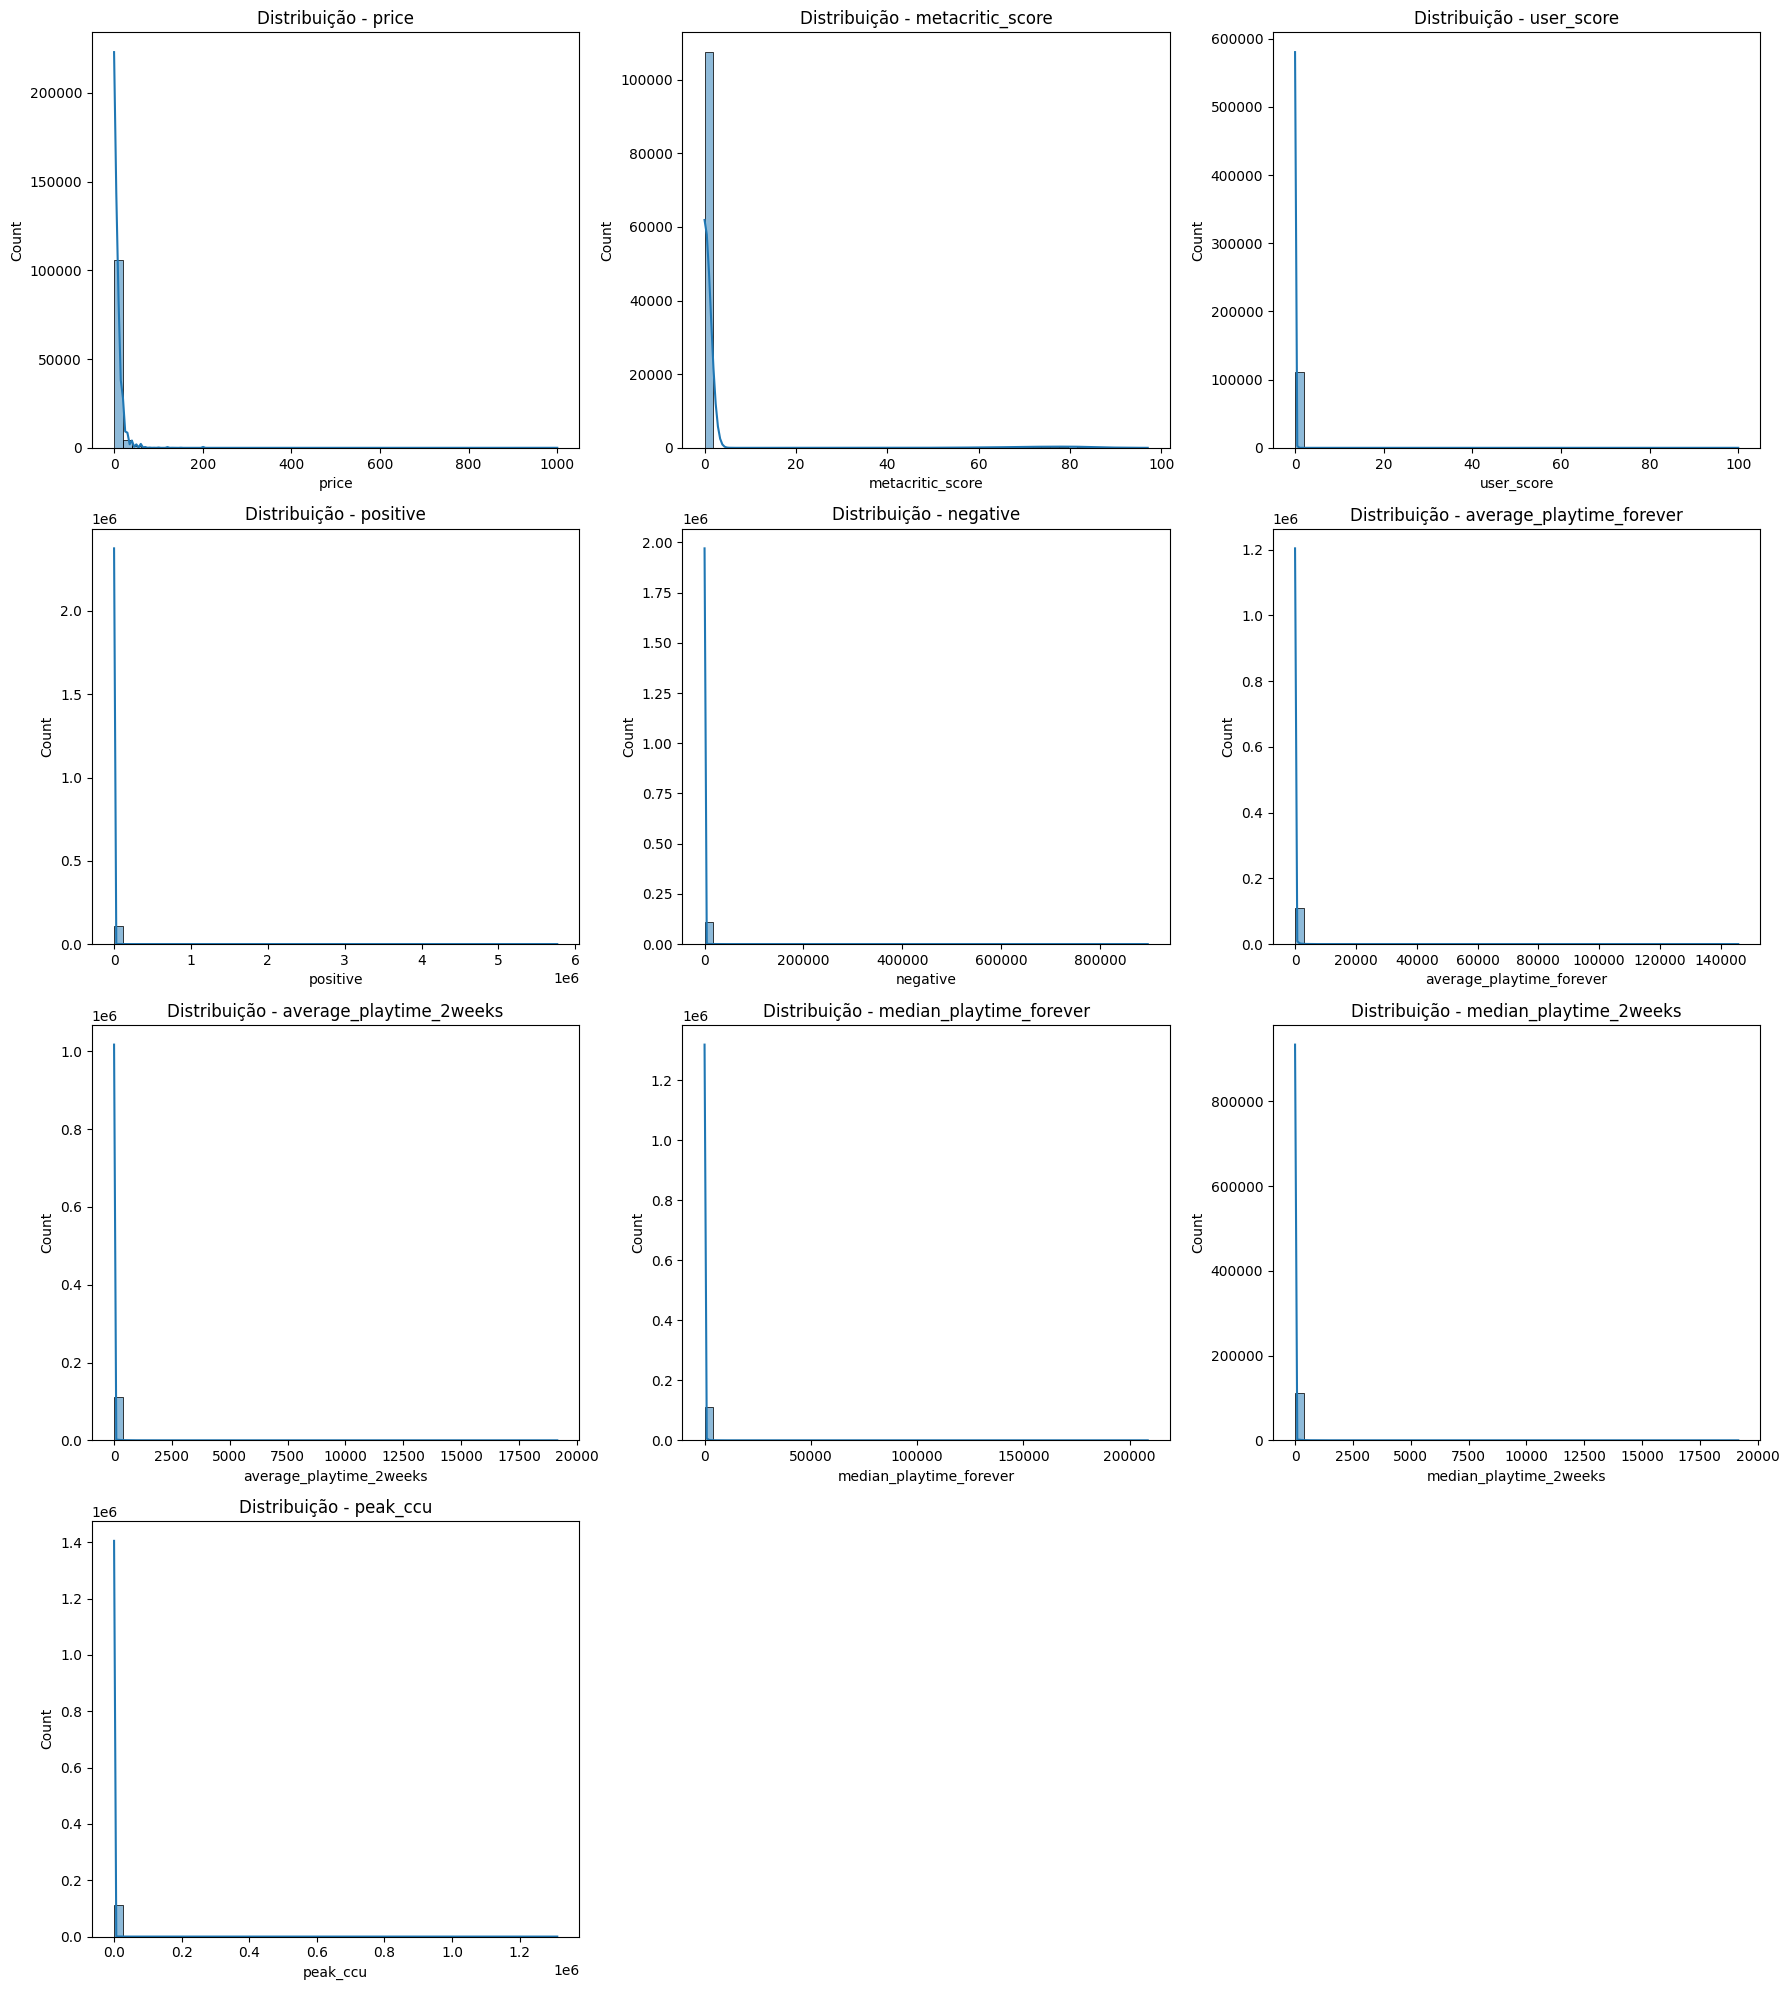

In [ ]:
# @title Histogramas - antes da limpeza
num_cols = df_sample.select_dtypes(include=[np.number]).columns


n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df_sample[col].dropna(), bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribuição - {col}")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

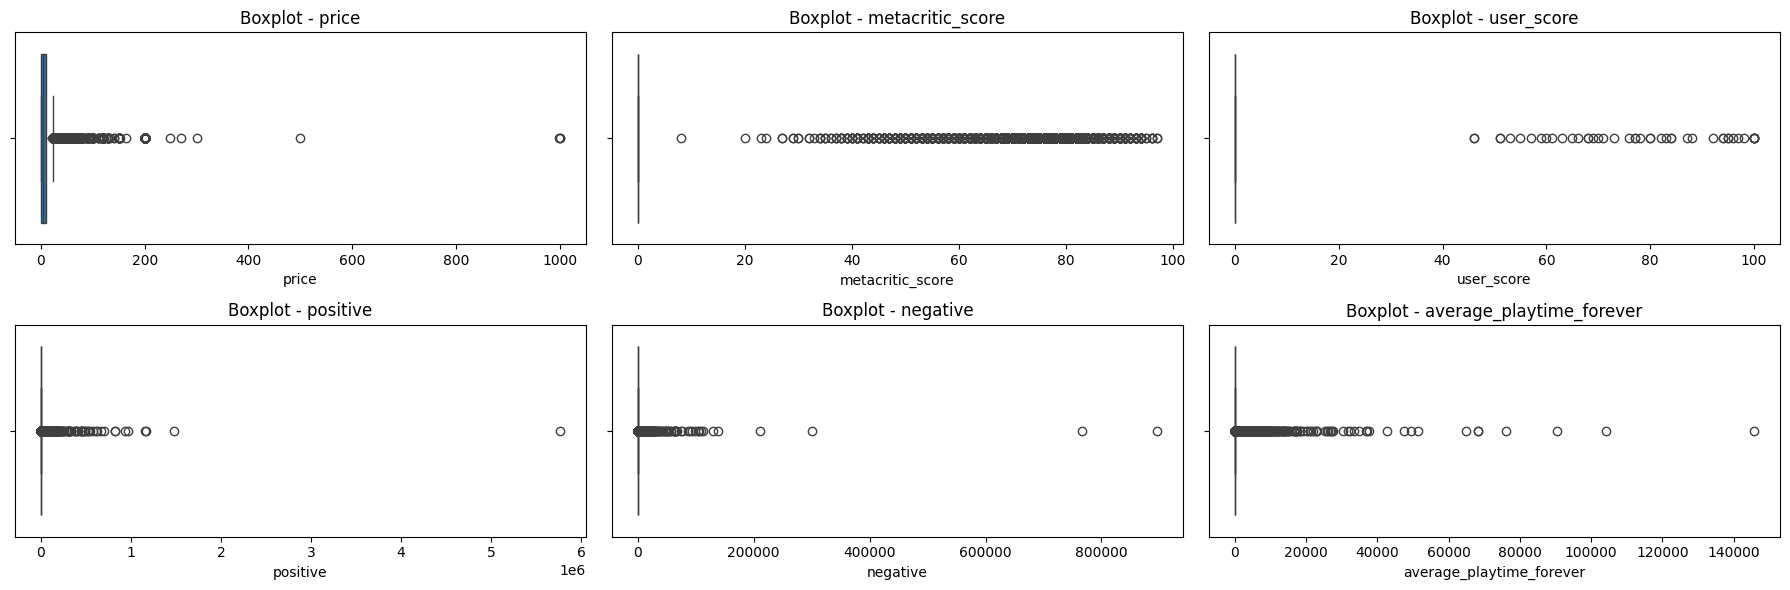

price: 5102 outliers
metacritic_score: 4005 outliers
user_score: 44 outliers
positive: 18765 outliers
negative: 18750 outliers
average_playtime_forever: 15229 outliers


In [ ]:
# @title Analise de Outliers - antes da limpeza
num_cols = df_sample.select_dtypes(include=[np.number]).columns[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df_sample[col].dropna(), ax=axes[i])
    axes[i].set_title(f"Boxplot - {col}")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

from scipy import stats
import numpy as np

for col in num_cols:
    Q1 = df_sample[col].quantile(0.25)
    Q3 = df_sample[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_sample[(df_sample[col] < (Q1 - 1.5*IQR)) | (df_sample[col] > (Q3 + 1.5*IQR))]
    print(f"{col}: {len(outliers)} outliers")

/tmp/ipython-input-815709672.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_months.index, y=top_months.values, palette="viridis")


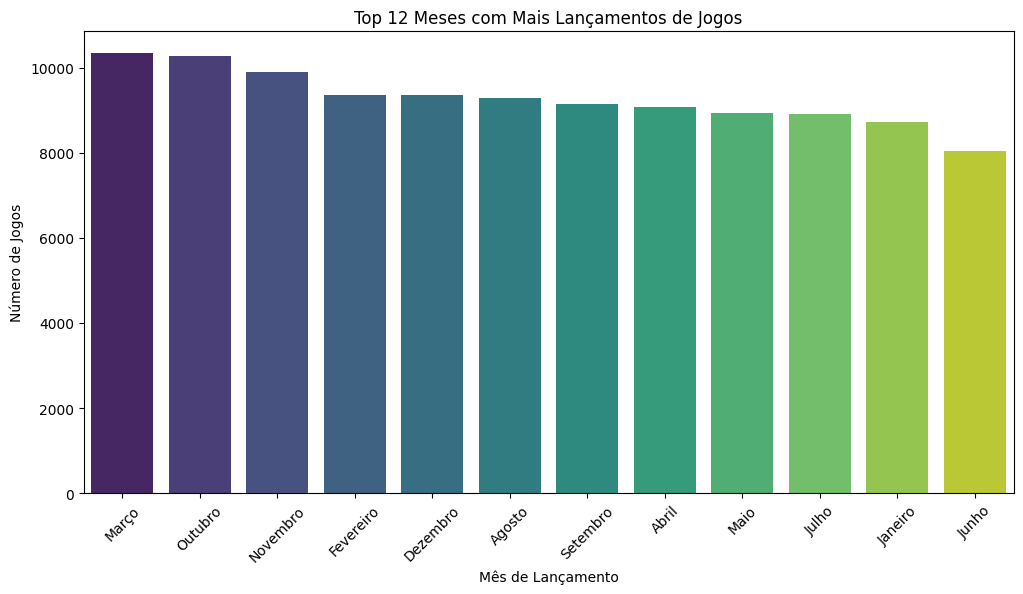

/tmp/ipython-input-815709672.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[count for item, count in top_items], y=[item for item, count in top_items], palette="viridis")


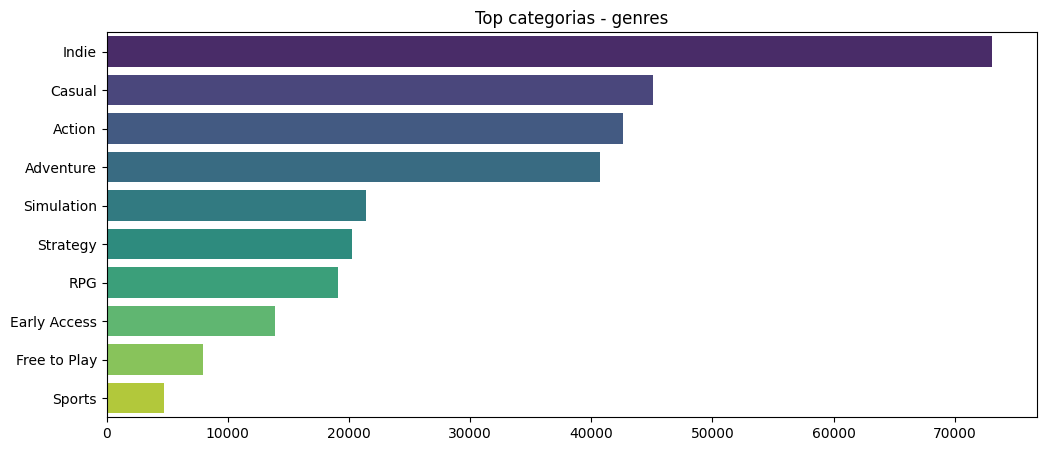

/tmp/ipython-input-815709672.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[count for item, count in top_items], y=[item for item, count in top_items], palette="viridis")


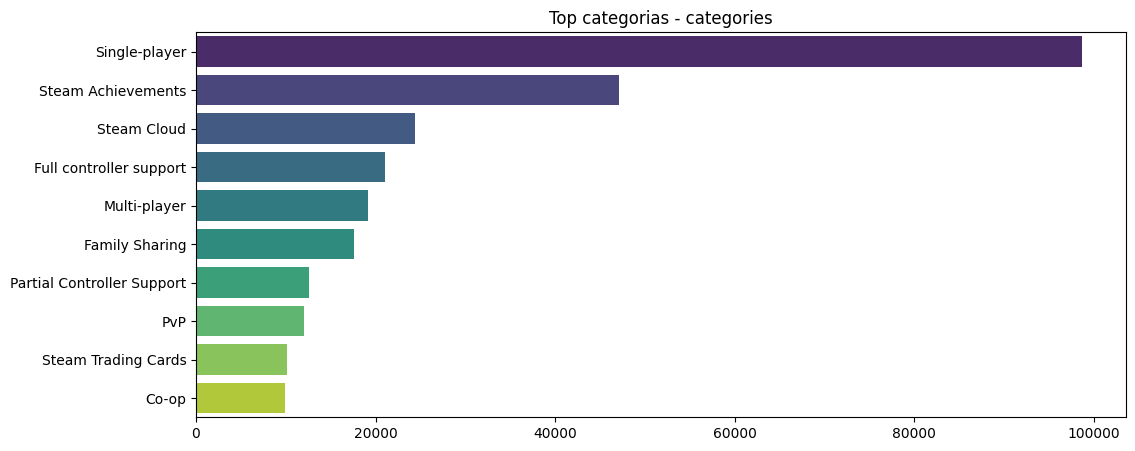

/tmp/ipython-input-815709672.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_years.values, y=top_years.index.astype(str), palette="viridis")


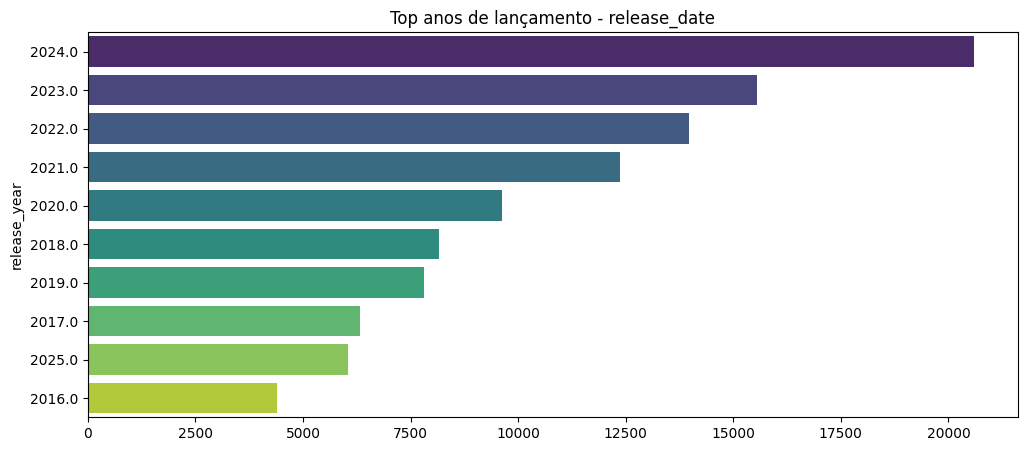

In [ ]:
# @title Tops generos, categorias e datas de lançamentos de jogos  - antes da limpeza
from collections import Counter

df_sample["release_date_dt"] = pd.to_datetime(df_sample["release_date"], errors="coerce")

df_sample["release_month"] = df_sample["release_date_dt"].dt.month

meses = {
    1: "Janeiro", 2: "Fevereiro", 3: "Março", 4: "Abril",
    5: "Maio", 6: "Junho", 7: "Julho", 8: "Agosto",
    9: "Setembro", 10: "Outubro", 11: "Novembro", 12: "Dezembro"
}
df_sample["release_month_name"] = df_sample["release_month"].map(meses)

top_months = df_sample["release_month_name"].value_counts().head(12)

plt.figure(figsize=(12,6))
sns.barplot(x=top_months.index, y=top_months.values, palette="viridis")
plt.title("Top 12 Meses com Mais Lançamentos de Jogos")
plt.xlabel("Mês de Lançamento")
plt.ylabel("Número de Jogos")
plt.xticks(rotation=45)
plt.show()


cat_cols_to_plot = ["genres", "categories", "release_date"]

for col in cat_cols_to_plot:
    if col in df_sample.columns:
        plt.figure(figsize=(12,5))
        if col in ["genres", "categories"]:
            all_items = [item for sublist in df_sample[col].dropna() for item in sublist]
            top_items = Counter(all_items).most_common(10)
            sns.barplot(x=[count for item, count in top_items], y=[item for item, count in top_items], palette="viridis")
            plt.title(f"Top categorias - {col}")
        elif col == "release_date":
            df_sample['release_year'] = pd.to_datetime(df_sample['release_date'], errors='coerce').dt.year
            top_years = df_sample['release_year'].value_counts().head(10)
            sns.barplot(x=top_years.values, y=top_years.index.astype(str), palette="viridis")
            plt.title(f"Top anos de lançamento - {col}")
            df_sample = df_sample.drop(columns=['release_year'])

        plt.show()

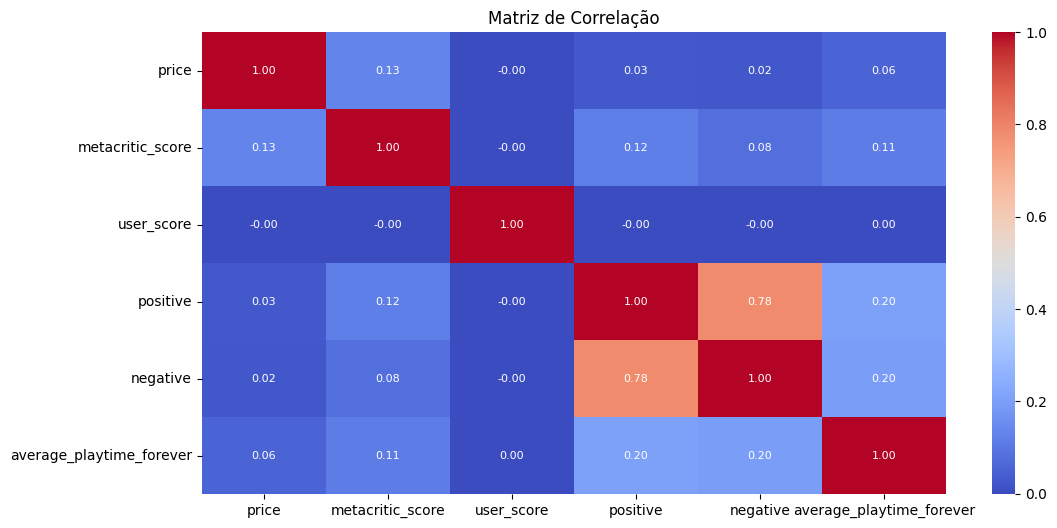

In [ ]:
# @title Matriz de Correlação - antes da limpeza
plt.figure(figsize=(12,6))
sns.heatmap(
    df_sample[num_cols].corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title("Matriz de Correlação")
plt.show()


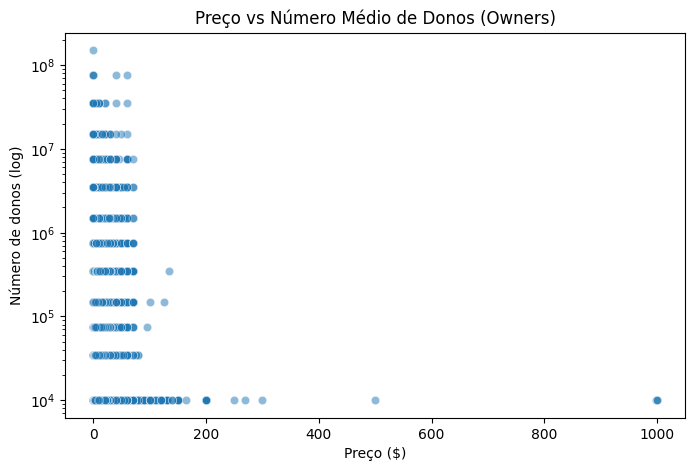

In [ ]:
# @title preço x número medio de owners - antes da limpeza
#Preço x Donos
if "price" in df_sample.columns and "estimated_owners" in df_sample.columns:
    df_sample["owners_min"] = df_sample["estimated_owners"].str.split("-").str[0].str.replace(",", "").astype(float)
    df_sample["owners_max"] = df_sample["estimated_owners"].str.split("-").str[1].str.replace(",", "").astype(float)
    df_sample["owners_mean"] = (df_sample["owners_min"] + df_sample["owners_max"]) / 2

    plt.figure(figsize=(8,5))
    sns.scatterplot(x="price", y="owners_mean", data=df_sample, alpha=0.5)
    plt.yscale("log")
    plt.title("Preço vs Número Médio de Donos (Owners)")
    plt.xlabel("Preço ($)")
    plt.ylabel("Número de donos (log)")
    plt.show()


# Conclusões da Analise com Graficos:
### Observações visuais:
- Todas as variáveis numéricas (price, positive, negative, playtime, peak_ccu, owners) estão altamente assimétricas (longa cauda à direita). A maioria dos valores concentra-se perto de 0, existem poucos pontos muito grandes e aparecem como outliers.
- price: muitos jogos grátis/baratos, alguns preços extremos, provavelmente bundles ou entradas errada (EX: 1000). Além disso, price parece ter correlação fraca com owners e com playtime.
- A maioria dos pontos (donos) está em jogos com preço baixo, incluindo grátis. Não há uma relação linear clara: jogos com muito owners podem ser grátis ou com preço baixo; alguns jogos pagos têm baixa tração. Isso sugere que preço por si só não prevê fortemente número de donos, outros fatores (marketing, qualidade, gênero, apoio da publisher, presença em promoção) podem importar.
- muitos lançamentos concentram-se no final/começo do ano e em março, útil para estratégia de lançamento (escolher meses estratégicos).
- e seu jogo se enquadra em gêneros muito saturados (ex.: Indie), você precisa diferenciar por qualidade/marketing.

### Metricas Candidatas:
- owners_mean: media de pessoas que tem o jogo.

- peak_ccu: pico de jogadores simultâneos, engajamento curto prazo (hype).

- average_playtime_forever/median_playtime_forever: engajamento longo prazo.

- positive, negative, total_reviews: satisfação/volume de feedback.

- approval_rate = positive / total_reviews: razão de aprovação.

- metacritic_score / user_score: qualidade percebida por críticos/usuários.


### Possiveis Problemas
- estimated_owners é faixa, não número exato, deixará o target menos preciso.

- Informações faltantes, discount com 87% nulos e tags/genres em formatos inconsistentes.

- Falta de variáveis de marketing (campanhas, exposição, mídia), modelo poderá não captar tudo que gera sucesso real.

- normalização dos dados (muitos proximos de 0 ou com muitos outliers).


# Preparando o Dataset:
### Colunas que seram mantidas:
  - release_date
  - required_age
  - price
  - windows
  - mac
  - linux
  - metacritic_score
  - achievements
  - supported_languages
  - full_audio_languages
  - packages
  - developers
  - publishers
  - categories
  - genres
  - tags

### Colunas que podem ser descartadas:
 - name: só serve para identificar o jogo
 - website, supportUrl, supportEmail: dados de contato
 - header_image, screenshots, movies: links/imagens
 - metacritic_url: só o metacritic_score já basta.
 - detailed_description, about_the_game, short_description, reviews: trabalhar com textos não vai ser o foco.
 - discount, notes: tem muitos NaN e não indicam nada.
 - dlc_count, recommendations, user_score, score_rank, positive, negative, estimated_owners, average_playtime_forever, average_playtime_2weeks, median_playtime_forever, median_playtime_2weeks, peak_ccu: Dados que um jogo em desenvolvimento não terão e não são os targets dessa pesquisa.  

### Colunas target:
 - estimated_owners
 - rendimento_total = estimated_owners * price

In [ ]:
# @title Dataframe com colunas selecionadas
desiredColumns = ['release_date',
                  'required_age',
                  'price',
                  'windows',
                  'mac',
                  'linux',
                  'metacritic_score',
                  'achievements',
                  'supported_languages',
                  'full_audio_languages',
                  'packages',
                  'developers',
                  'publishers',
                  'categories',
                  'genres',
                  'estimated_owners',
                  'tags']

df_selected = df_sample.copy(True)
for column in df_sample.columns:
  if (column not in desiredColumns):
    df_selected = df_selected.drop(columns=[column])

# Limpeza do Dataset

Colunas:

- **release_date:** Transformamos os dados em datetime para facilitar a manipulação e retiramos os registros com dia indefinido.
- **required_age:** Retiramos essa coluna devido a grande quantidade de valores repetidos ou incorretos (99% com valores igual a zero)
- **price:** Transformação de preço utilizando log(preço + 1) para diminuir o efeito de outliers
- **windows:** Nada para limpar
- **mac:** Nada para limpar
- **linux:** Nada para limpar
- **metacritic_score:** Valores 0 (indicam a falta de um score) foi trocado por -1
- **achievements:** Nada para limpar
- **supported_languages:**
- **full_audio_languages:**
- **packages:**
- **developers:**
- **publishers:**
- **categories:**
- **genres:**
- **tags:**

Visualização pre-limpeza

In [ ]:
# @title
for column in df_selected.columns:
  if (type(df_selected[column].values[0]) == list or type(df_selected[column].values[0]) == dict):
    continue
  print(f"{column}:", df_selected[column].min(), "-", df_selected[column].max())

print("DataFrame before cleaning:")
display(df_selected.head())
print("\nShape before cleaning:", df_selected.shape)

df_clean = df_selected.copy(True)

release_date: Apr 1, 1999 - Sep 9, 2024
required_age: 0 - 21
price: 0.0 - 999.98
windows: False - True
mac: False - True
linux: False - True
metacritic_score: 0 - 97
achievements: 0 - 9821
estimated_owners: 0 - 0 - 50000000 - 100000000
DataFrame before cleaning:


,release_date,required_age,price,windows,mac,linux,metacritic_score,achievements,supported_languages,full_audio_languages,packages,developers,publishers,categories,genres,estimated_owners,tags
20200,"Oct 21, 2008",0,19.99,True,False,False,0,30,[English],[],"[{'title': 'Buy Galactic Bowling', 'descriptio...",[Perpetual FX Creative],[Perpetual FX Creative],"[Single-player, Multi-player, Steam Achievemen...","[Casual, Indie, Sports]",0 - 20000,"{'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow..."
655370,"Oct 12, 2017",0,0.99,True,True,False,0,12,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Train Bandit', 'description': ...",[Rusty Moyher],[Wild Rooster],"[Single-player, Steam Achievements, Full contr...","[Action, Indie]",0 - 20000,"{'Indie': 109, 'Action': 103, 'Pixel Graphics'..."
1732930,"Nov 17, 2021",0,4.99,True,False,False,0,0,"[English, Portuguese - Brazil]",[],"[{'title': 'Buy Jolt Project', 'description': ...",[Campião Games],[Campião Games],[Single-player],"[Action, Adventure, Indie, Strategy]",0 - 20000,[]
1355720,"Jul 23, 2020",0,5.99,True,True,True,0,0,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Henosis™', 'description': '', ...",[Odd Critter Games],[Odd Critter Games],"[Single-player, Full controller support]","[Adventure, Casual, Indie]",0 - 20000,"{'2D Platformer': 161, 'Atmospheric': 154, 'Su..."
1139950,"Feb 3, 2020",0,0.00,True,True,False,0,17,"[English, Spanish - Spain]",[],[],[Unusual Games],[Unusual Games],"[Single-player, Steam Achievements]","[Adventure, Indie]",0 - 20000,"{'Indie': 42, 'Adventure': 41, 'Nudity': 22, '..."



Shape before cleaning: (111452, 17)


Limpando Metacritic Score

In [ ]:
# @title
def CleanDataframe(dt):
  #Cleaning Metacritic Score
  dt['metacritic_score'] = dt['metacritic_score'].replace(0, -1)

  #Transforming release_date in datetime for easier access
  dt['release_date'] = pd.to_datetime(dt['release_date'], errors='coerce')
  #removing the columns with null values (no day)
  dt.dropna(subset=['release_date'], inplace = True)

  # Removing required_age column
  dt = dt.drop(columns=['required_age'])

  # Transforming price with log(price + 1)
  dt['price'] = np.log(dt['price'] + 1)

  # Handling price outliers using IQR method
  #Q1_price = dt['price'].quantile(0.25)
  #Q3_price = dt['price'].quantile(0.75)
  #IQR_price = Q3_price - Q1_price
  #lower_bound_price = Q1_price - 1.5 * IQR_price
  #upper_bound_price = Q3_price + 1.5 * IQR_price

  # Remove outliers
  #print("\nShape after cleaning:", dt.shape)
  #display(dt[(dt['price'] < lower_bound_price) | (dt['price'] > upper_bound_price)].head())
  #dt = dt[(dt['price'] >= lower_bound_price) & (dt['price'] <= upper_bound_price)]

  return dt

print("DataFrame before cleaning:")
display(df_clean.head())
print("\nShape before cleaning:", df_clean.shape)

df_clean = CleanDataframe(df_clean);

print("DataFrame after cleaning:")
display(df_clean.head())
print("\nShape after cleaning:", df_clean.shape)

DataFrame before cleaning:


,release_date,required_age,price,windows,mac,linux,metacritic_score,achievements,supported_languages,full_audio_languages,packages,developers,publishers,categories,genres,estimated_owners,tags
20200,"Oct 21, 2008",0,19.99,True,False,False,0,30,[English],[],"[{'title': 'Buy Galactic Bowling', 'descriptio...",[Perpetual FX Creative],[Perpetual FX Creative],"[Single-player, Multi-player, Steam Achievemen...","[Casual, Indie, Sports]",0 - 20000,"{'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow..."
655370,"Oct 12, 2017",0,0.99,True,True,False,0,12,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Train Bandit', 'description': ...",[Rusty Moyher],[Wild Rooster],"[Single-player, Steam Achievements, Full contr...","[Action, Indie]",0 - 20000,"{'Indie': 109, 'Action': 103, 'Pixel Graphics'..."
1732930,"Nov 17, 2021",0,4.99,True,False,False,0,0,"[English, Portuguese - Brazil]",[],"[{'title': 'Buy Jolt Project', 'description': ...",[Campião Games],[Campião Games],[Single-player],"[Action, Adventure, Indie, Strategy]",0 - 20000,[]
1355720,"Jul 23, 2020",0,5.99,True,True,True,0,0,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Henosis™', 'description': '', ...",[Odd Critter Games],[Odd Critter Games],"[Single-player, Full controller support]","[Adventure, Casual, Indie]",0 - 20000,"{'2D Platformer': 161, 'Atmospheric': 154, 'Su..."
1139950,"Feb 3, 2020",0,0.00,True,True,False,0,17,"[English, Spanish - Spain]",[],[],[Unusual Games],[Unusual Games],"[Single-player, Steam Achievements]","[Adventure, Indie]",0 - 20000,"{'Indie': 42, 'Adventure': 41, 'Nudity': 22, '..."



Shape before cleaning: (111452, 17)
DataFrame after cleaning:


,release_date,price,windows,mac,linux,metacritic_score,achievements,supported_languages,full_audio_languages,packages,developers,publishers,categories,genres,estimated_owners,tags
20200,2008-10-21,3.044046,True,False,False,-1,30,[English],[],"[{'title': 'Buy Galactic Bowling', 'descriptio...",[Perpetual FX Creative],[Perpetual FX Creative],"[Single-player, Multi-player, Steam Achievemen...","[Casual, Indie, Sports]",0 - 20000,"{'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow..."
655370,2017-10-12,0.688135,True,True,False,-1,12,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Train Bandit', 'description': ...",[Rusty Moyher],[Wild Rooster],"[Single-player, Steam Achievements, Full contr...","[Action, Indie]",0 - 20000,"{'Indie': 109, 'Action': 103, 'Pixel Graphics'..."
1732930,2021-11-17,1.790091,True,False,False,-1,0,"[English, Portuguese - Brazil]",[],"[{'title': 'Buy Jolt Project', 'description': ...",[Campião Games],[Campião Games],[Single-player],"[Action, Adventure, Indie, Strategy]",0 - 20000,[]
1355720,2020-07-23,1.944481,True,True,True,-1,0,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Henosis™', 'description': '', ...",[Odd Critter Games],[Odd Critter Games],"[Single-player, Full controller support]","[Adventure, Casual, Indie]",0 - 20000,"{'2D Platformer': 161, 'Atmospheric': 154, 'Su..."
1139950,2020-02-03,0.000000,True,True,False,-1,17,"[English, Spanish - Spain]",[],[],[Unusual Games],[Unusual Games],"[Single-player, Steam Achievements]","[Adventure, Indie]",0 - 20000,"{'Indie': 42, 'Adventure': 41, 'Nudity': 22, '..."



Shape after cleaning: (111321, 16)


0


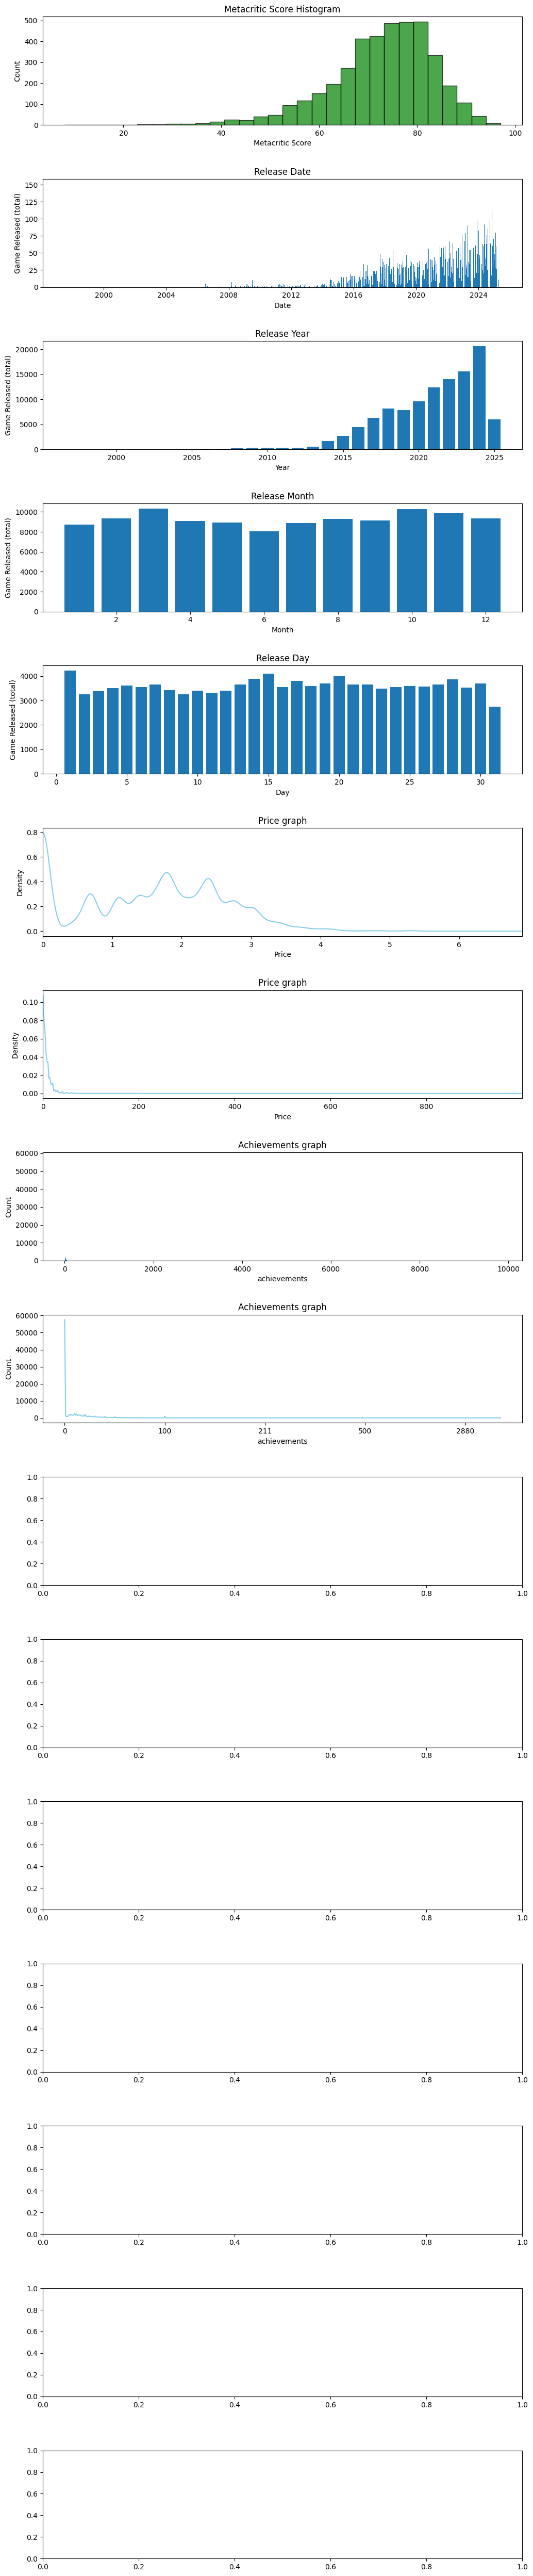

In [ ]:
# @title
def PlotDataFrame():
  fig, axes = plt.subplots(16, 1, figsize=(12, 8*8))
  index = 0

  axes[index].hist(df_clean['metacritic_score'][df_clean['metacritic_score'] > -1], bins=30, color='green', alpha=0.7, edgecolor='black')
  axes[index].set_xlabel('Metacritic Score')
  axes[index].set_ylabel('Count')
  axes[index].set_title('Metacritic Score Histogram')
  index+=1

  plot = df_clean['release_date'].value_counts().sort_index()
  axes[index].bar(plot.index, plot.values)
  axes[index].set_xlabel('Date')
  axes[index].set_ylabel('Game Released (total)')
  axes[index].set_title('Release Date')
  index+=1

  plot = df_clean['release_date'].dt.year.value_counts().sort_index()
  axes[index].bar(plot.index, plot.values)
  axes[index].set_xlabel('Year')
  axes[index].set_ylabel('Game Released (total)')
  axes[index].set_title('Release Year')
  index+=1

  plot = df_clean['release_date'].dt.month.value_counts().sort_index()
  axes[index].bar(plot.index, plot.values)
  axes[index].set_xlabel('Month')
  axes[index].set_ylabel('Game Released (total)')
  axes[index].set_title('Release Month')
  index+=1

  plot = df_clean['release_date'].dt.day.value_counts().sort_index()
  axes[index].bar(plot.index, plot.values)
  axes[index].set_xlabel('Day')
  axes[index].set_ylabel('Game Released (total)')
  axes[index].set_title('Release Day')
  index+=1

  column = 'price'
  df_clean['price'].plot(kind='kde', color='skyblue', ax=axes[index])
  axes[index].set_xlim(df_clean[column].min(), df_clean[column].max())
  axes[index].set_xlabel("Price")
  axes[index].set_ylabel('Density')
  axes[index].set_title('Price graph')
  index += 1

  column = 'price'
  df_visualization = df_clean.copy(True)
  df_visualization[column] = np.exp(df_clean[column]) - 1
  df_visualization[column].plot(kind='kde', color='skyblue', ax=axes[index])
  axes[index].set_xlim(df_visualization[column].min(), df_visualization[column].max())
  axes[index].set_xlabel("Price")
  axes[index].set_ylabel('Density')
  axes[index].set_title('Price graph')
  index += 1

  plot = df_clean['achievements'].value_counts().sort_index()
  axes[index].bar(plot.index, plot.values)
  axes[index].set_xlabel("achievements")
  axes[index].set_ylabel('Count')
  axes[index].set_title('Achievements graph')
  index+=1

  column = 'achievements'
  print(df_clean[column].isnull().sum())
  df_clean[column].value_counts().sort_index().plot(ax=axes[index], color='skyblue')
  axes[index].set_xlabel("achievements")
  axes[index].set_ylabel('Count')
  axes[index].set_title('Achievements graph')
  index += 1

  plt.subplots_adjust(wspace=0.3, hspace=0.5)
  plt.show()

  return

PlotDataFrame()

In [ ]:
# Processando colunas com listas e dicionários
df_clean['supported_languages_count'] = df_clean['supported_languages'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['full_audio_languages_count'] = df_clean['full_audio_languages'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['packages_count'] = df_clean['packages'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['developers_count'] = df_clean['developers'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['publishers_count'] = df_clean['publishers'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['categories_count'] = df_clean['categories'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['genres_count'] = df_clean['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['tags_count'] = df_clean['tags'].apply(lambda x: len(x) if isinstance(x, dict) else 0)

# Exibindo as novas colunas e as primeiras linhas do DataFrame limpo
print("Novas colunas de contagem adicionadas.")
display(df_clean[['supported_languages_count', 'full_audio_languages_count', 'packages_count', 'developers_count', 'publishers_count', 'categories_count', 'genres_count', 'tags_count']].head())

print("\nDataFrame após limpeza e adição de contagens:")
display(df_clean.head(10))

print("\nShape após limpeza e adição de contagens:", df_clean.shape)

Novas colunas de contagem adicionadas.


,supported_languages_count,full_audio_languages_count,packages_count,developers_count,publishers_count,categories_count,genres_count,tags_count
20200,1,0,1,1,1,4,3,4
655370,10,0,1,1,1,7,2,20
1732930,2,0,1,1,1,1,4,0
1355720,11,0,1,1,1,2,3,19
1139950,2,0,0,1,1,2,2,6



DataFrame após limpeza e adição de contagens:


,release_date,price,windows,mac,linux,metacritic_score,achievements,supported_languages,full_audio_languages,packages,...,estimated_owners,tags,supported_languages_count,full_audio_languages_count,packages_count,developers_count,publishers_count,categories_count,genres_count,tags_count
20200,2008-10-21,3.044046,True,False,False,-1,30,[English],[],"[{'title': 'Buy Galactic Bowling', 'descriptio...",...,0 - 20000,"{'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...",1,0,1,1,1,4,3,4
655370,2017-10-12,0.688135,True,True,False,-1,12,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Train Bandit', 'description': ...",...,0 - 20000,"{'Indie': 109, 'Action': 103, 'Pixel Graphics'...",10,0,1,1,1,7,2,20
1732930,2021-11-17,1.790091,True,False,False,-1,0,"[English, Portuguese - Brazil]",[],"[{'title': 'Buy Jolt Project', 'description': ...",...,0 - 20000,[],2,0,1,1,1,1,4,0
1355720,2020-07-23,1.944481,True,True,True,-1,0,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Henosis™', 'description': '', ...",...,0 - 20000,"{'2D Platformer': 161, 'Atmospheric': 154, 'Su...",11,0,1,1,1,2,3,19
1139950,2020-02-03,0.000000,True,True,False,-1,17,"[English, Spanish - Spain]",[],[],...,0 - 20000,"{'Indie': 42, 'Adventure': 41, 'Nudity': 22, '...",2,0,0,1,1,2,2,6
1469160,2021-02-26,0.000000,True,False,False,-1,0,[English],[],[],...,50000 - 100000,"{'Turn-Based Combat': 292, 'Massively Multipla...",1,0,0,1,1,8,6,20
1659180,2022-01-09,2.484073,True,False,False,-1,62,"[English, Russian, Danish]",[],"[{'title': 'Buy TD Worlds', 'description': '',...",...,0 - 20000,"{'Tower Defense': 232, 'Rogue-lite': 226, 'RTS...",3,0,1,1,1,3,2,20
1968760,2022-05-05,2.396986,True,False,False,-1,0,"[English, German]","[English, German]",[{'title': 'Buy Legend of Rome - The Wrath of ...,...,0 - 20000,[],2,2,1,1,1,2,1,0
1178150,2020-04-02,2.771964,True,False,False,-1,25,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy MazM: Jekyll and Hyde', 'descr...",...,0 - 20000,"{'Adventure': 53, 'Simulation': 50, 'RPG': 49,...",10,0,1,1,1,3,4,6
320150,2014-11-11,1.607436,True,True,True,-1,32,"[English, Polish, French, Italian, German, Spa...","[English, Japanese]","[{'title': 'Buy Deadlings: Rotten Edition', 'd...",...,50000 - 100000,"{'Action': 27, 'Indie': 27, 'Adventure': 26, '...",9,2,1,1,1,5,3,6



Shape após limpeza e adição de contagens: (111321, 24)


In [ ]:
for column in df_clean.columns:
  if (type(df_clean[column].values[0]) == list or type(df_clean[column].values[0]) == dict):
    continue
  print(column, df_clean[column].min(), "-", df_clean[column].max())

release_date 1997-06-30 00:00:00 - 2025-05-30 00:00:00
price 0.0 - 6.908734799095638
windows False - True
mac False - True
linux False - True
metacritic_score -1 - 97
achievements 0 - 9821
estimated_owners 0 - 0 - 50000000 - 100000000
supported_languages_count 0 - 103
full_audio_languages_count 0 - 103
packages_count 0 - 3
developers_count 0 - 41
publishers_count 0 - 10
categories_count 0 - 22
genres_count 0 - 19
tags_count 0 - 21


In [ ]:
total_rows = len(df_clean)
empty_lists_count = df_clean['full_audio_languages'].apply(lambda x: len(x) == 0 if isinstance(x, list) else False).sum()

print(f"Número de listas vazias na coluna 'full_audio_languages': {empty_lists_count}")
print(f"Total de linhas no DataFrame: {total_rows}")
print(f"Proporção de listas vazias: {empty_lists_count / total_rows:.2%}")

Número de listas vazias na coluna 'full_audio_languages': 65758
Total de linhas no DataFrame: 111321
Proporção de listas vazias: 59.07%


# Engenharia de Features:

**Objetivos**

- Gerar novas features
- Normalizar features

**Lista de features novas:**

- Numero de pacotes
- Data de lançamento (formato D/M/A)
- Transformação da data de lançamento feature circular (seno, cosseno)
- Transformar variaveis booleanas em 0 ou 1 (windows, mac, linux)
- Separar os gêneros principais em colunas diferentes (casual, indie, esporte, ação, aventura, outros, etc)
- Criar coluna self-published (cuidado com dados repetidos)

In [ ]:
df_eng = df_clean.copy(True)
for index in df_eng.index:
  currentValue = df_eng.at[index, 'packages'];
  if (type(currentValue) == int):
    continue
  df_eng.at[index, 'packages'] = len(currentValue);

In [ ]:
print(df_clean['packages'])

20200      [{'title': 'Buy Galactic Bowling', 'descriptio...
655370     [{'title': 'Buy Train Bandit', 'description': ...
1732930    [{'title': 'Buy Jolt Project', 'description': ...
1355720    [{'title': 'Buy Henosis™', 'description': '', ...
1139950                                                   []
                                 ...                        
3600970    [{'title': 'Buy Paragon Of Time', 'description...
3543710    [{'title': 'Buy A Few Days With : Hazel', 'des...
3265370    [{'title': 'Buy MosGhost', 'description': '', ...
3423620                                                   []
3183790    [{'title': 'Buy Defense Of Fort Burton', 'desc...
Name: packages, Length: 111321, dtype: object


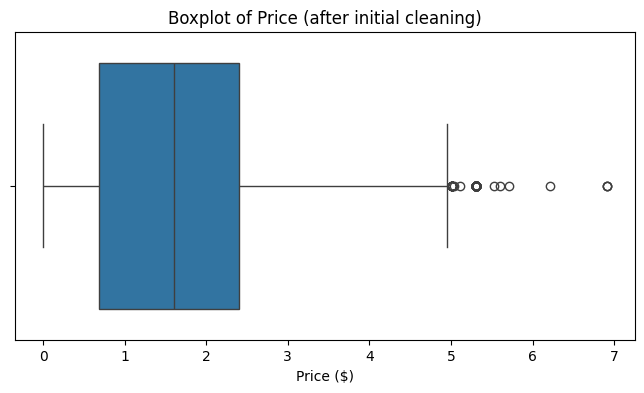

Number of outliers in price column: 135


In [ ]:
# Visualize outliers in the price column again
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_clean['price'])
plt.title('Boxplot of Price (after initial cleaning)')
plt.xlabel('Price ($)')
plt.show()

print(f"Number of outliers in price column: {len(df_clean[df_clean['price'] > df_clean['price'].quantile(0.75) + 1.5*(df_clean['price'].quantile(0.75) - df_clean['price'].quantile(0.25))])}")

In [ ]:
# @title Normalização do DataFrame

# Selecionar as colunas numéricas para normalizar
# Excluindo colunas de contagem que foram criadas para análise e podem não ser ideais para clustering direto
numeric_cols_for_scaling = ['price', 'metacritic_score', 'achievements',
                            'supported_languages_count', 'full_audio_languages_count',
                            'packages_count', 'developers_count', 'publishers_count',
                            'categories_count', 'genres_count', 'tags_count']

# Criar uma cópia do DataFrame para evitar modificar o original diretamente
df_scaled = df_clean.copy()

# Inicializar o MinMaxScaler
scaler = MinMaxScaler()

# Aplicar a normalização nas colunas selecionadas
df_scaled[numeric_cols_for_scaling] = scaler.fit_transform(df_scaled[numeric_cols_for_scaling])

print("DataFrame normalizado:")
display(df_scaled.head())

DataFrame normalizado:


,release_date,price,windows,mac,linux,metacritic_score,achievements,supported_languages,full_audio_languages,packages,...,estimated_owners,tags,supported_languages_count,full_audio_languages_count,packages_count,developers_count,publishers_count,categories_count,genres_count,tags_count
20200,2008-10-21,0.440608,True,False,False,0.0,0.003055,[English],[],"[{'title': 'Buy Galactic Bowling', 'descriptio...",...,0 - 20000,"{'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...",0.009709,0.0,0.333333,0.02439,0.1,0.181818,0.157895,0.190476
655370,2017-10-12,0.099604,True,True,False,0.0,0.001222,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Train Bandit', 'description': ...",...,0 - 20000,"{'Indie': 109, 'Action': 103, 'Pixel Graphics'...",0.097087,0.0,0.333333,0.02439,0.1,0.318182,0.105263,0.952381
1732930,2021-11-17,0.259106,True,False,False,0.0,0.000000,"[English, Portuguese - Brazil]",[],"[{'title': 'Buy Jolt Project', 'description': ...",...,0 - 20000,[],0.019417,0.0,0.333333,0.02439,0.1,0.045455,0.210526,0.000000
1355720,2020-07-23,0.281452,True,True,True,0.0,0.000000,"[English, French, Italian, German, Spanish - S...",[],"[{'title': 'Buy Henosis™', 'description': '', ...",...,0 - 20000,"{'2D Platformer': 161, 'Atmospheric': 154, 'Su...",0.106796,0.0,0.333333,0.02439,0.1,0.090909,0.157895,0.904762
1139950,2020-02-03,0.000000,True,True,False,0.0,0.001731,"[English, Spanish - Spain]",[],[],...,0 - 20000,"{'Indie': 42, 'Adventure': 41, 'Nudity': 22, '...",0.019417,0.0,0.000000,0.02439,0.1,0.090909,0.105263,0.285714


In [ ]:
# @title Separando dados de treino e teste
from sklearn.model_selection import train_test_split

# Features
X = df_clean.copy()
# Target
y = df_clean['estimated_owners']

# PASSO 1: Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("✂️ Dados divididos:")
print(f"  Treino: {len(X_train)} amostras")
print(f"  Teste: {len(X_test)} amostras")

✂️ Dados divididos:
  Treino: 77924 amostras
  Teste: 33397 amostras


In [ ]:
# @title Treinando modelo de Machine Learning

from sklearn.tree import DecisionTreeRegressor

# Usando uma Árvore de Decisão
modelo_regressao = DecisionTreeRegressor(max_depth=3, random_state=42)

modelo_regressao.fit(X_train, y_train)

print("✅ Modelo treinado com sucesso!")

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
# @title Previsões do Modelo

from sklearn.metrics import mean_squared_error, r2_score

# Fazer previsões
y_reg_pred_train = modelo_regressao.predict(X_train)
y_reg_pred_test = modelo_regressao.predict(X_test)

# Avaliar
r2_train = r2_score(y_train, y_reg_pred_train)
r2_test = r2_score(y_test, y_reg_pred_test)

print("📊 Avaliação do Modelo de Regressão:")
print(f"  R² no TREINO: {r2_train:.3f}")
print(f"  R² no TESTE: {r2_test:.3f}")
print("\n💡 Interpretação:")
print(f"  O modelo explica {r2_test:.1%} da variação nos dados de teste")

TypeError: float() argument must be a string or a real number, not 'Timestamp'

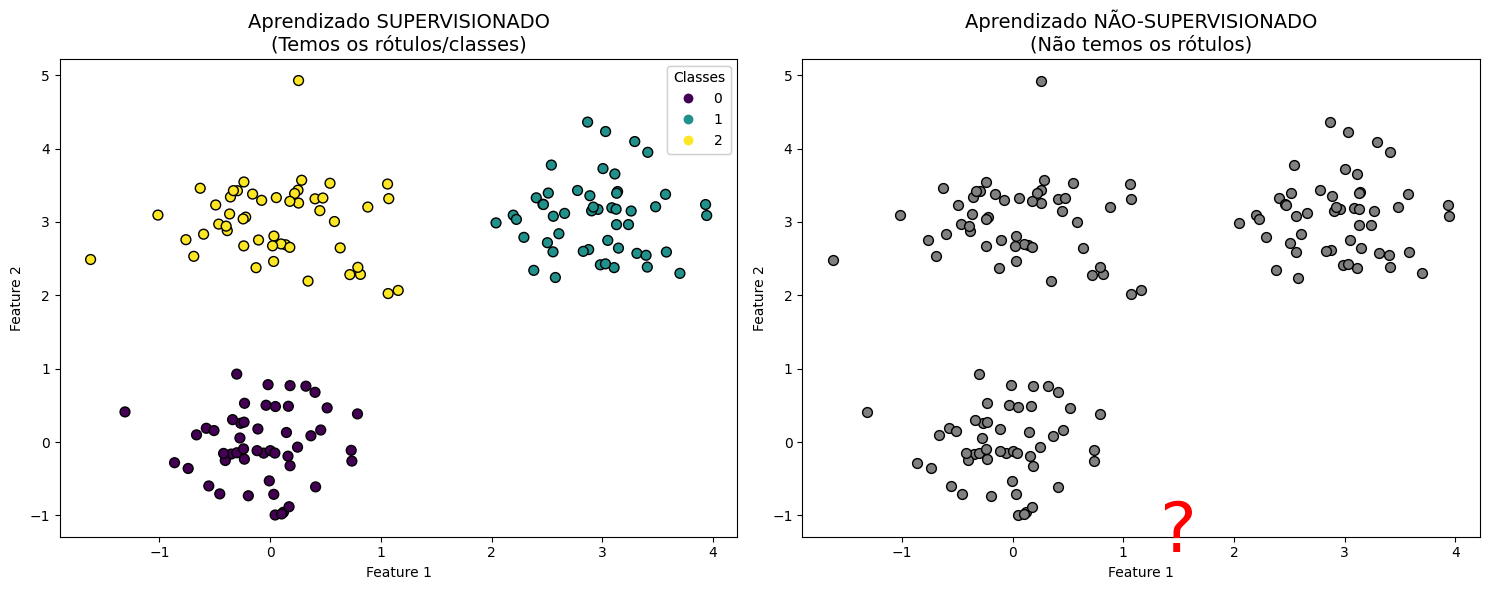

No aprendizado SUPERVISIONADO, conhecemos as classes e treinamos o modelo para prever novos casos.
No aprendizado NÃO-SUPERVISIONADO, precisamos descobrir os grupos/padrões por conta própria!


In [ ]:
# @title
# Comparação visual: Supervisionado vs Não-Supervisionado
np.random.seed(42)

# Gerar dados sintéticos
n_samples = 150
centers = [[0, 0], [3, 3], [0, 3]]
X, y_true = datasets.make_blobs(n_samples=n_samples, centers=centers,
                                n_features=2, cluster_std=0.5, random_state=42)

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Aprendizado Supervisionado (com labels)
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=50, edgecolors='black')
ax1.set_title('Aprendizado SUPERVISIONADO\n(Temos os rótulos/classes)', fontsize=14)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
legend1 = ax1.legend(*scatter1.legend_elements(), title="Classes", loc="upper right")
ax1.add_artist(legend1)

# Aprendizado Não-Supervisionado (sem labels)
ax2.scatter(X[:, 0], X[:, 1], c='gray', s=50, edgecolors='black')
ax2.set_title('Aprendizado NÃO-SUPERVISIONADO\n(Não temos os rótulos)', fontsize=14)
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.text(1.5, -1.5, '?', fontsize=50, color='red', ha='center')

plt.tight_layout()
plt.show()

print("No aprendizado SUPERVISIONADO, conhecemos as classes e treinamos o modelo para prever novos casos.")
print("No aprendizado NÃO-SUPERVISIONADO, precisamos descobrir os grupos/padrões por conta própria!")

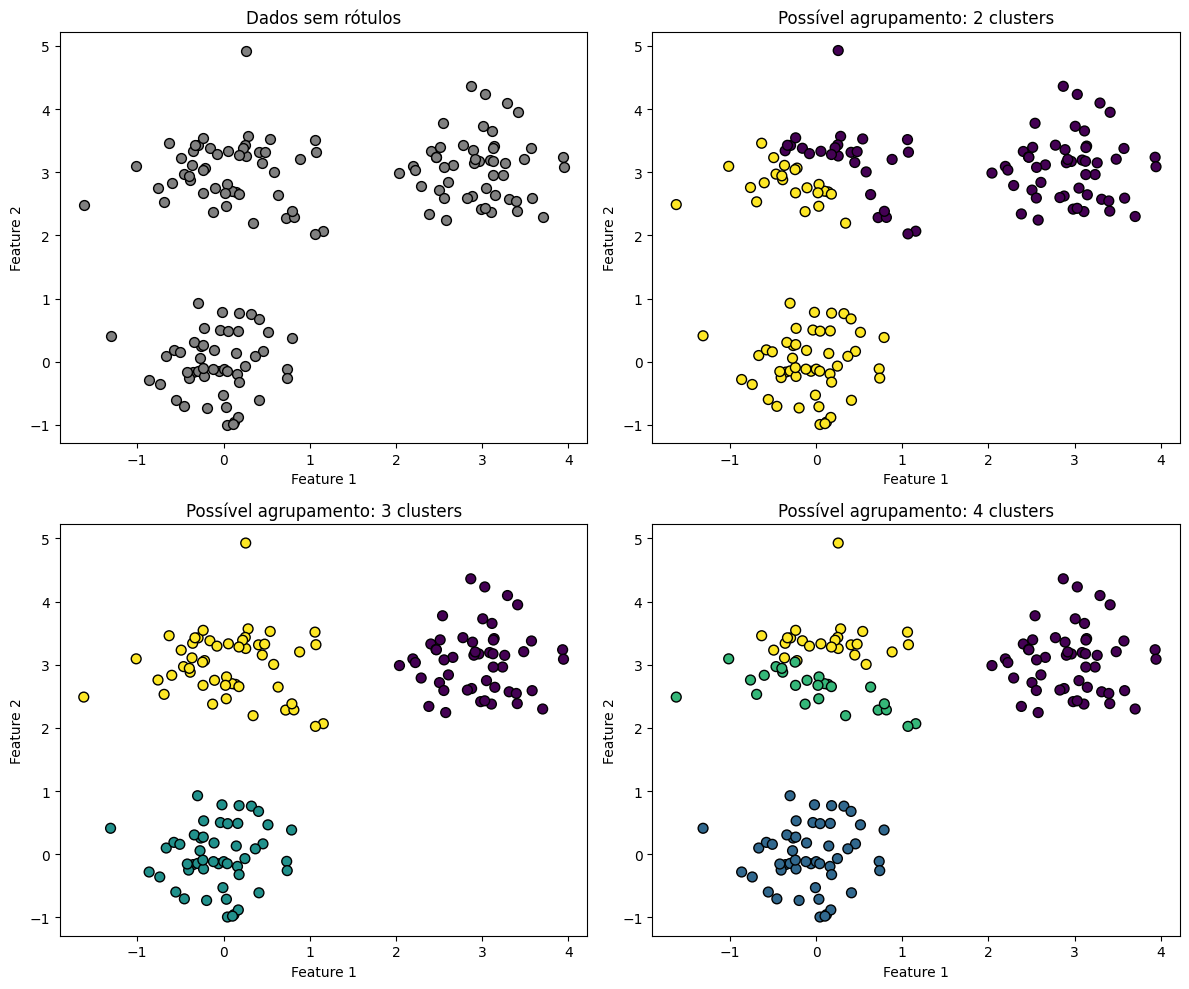


💡 INSIGHT IMPORTANTE:
Diferentemente da classificação, não há uma 'resposta certa' única no clustering!
O número e a natureza dos clusters dependem do objetivo da análise.


In [ ]:
# @title
# Demonstração: O mesmo conjunto de dados pode ter diferentes agrupamentos válidos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Dados originais
axes[0].scatter(X[:, 0], X[:, 1], c='gray', s=50, edgecolors='black')
axes[0].set_title('Dados sem rótulos')

# Diferentes possibilidades de agrupamento
n_clusters_options = [2, 3, 4]

for i, n_clusters in enumerate(n_clusters_options):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    axes[i+1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolors='black')
    axes[i+1].set_title(f'Possível agrupamento: {n_clusters} clusters')

for ax in axes:
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT IMPORTANTE:")
print("Diferentemente da classificação, não há uma 'resposta certa' única no clustering!")
print("O número e a natureza dos clusters dependem do objetivo da análise.")